## Simplified Bipartite Example

### Library Imports

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as stat
import networkx as nx
import statistics
import random
import copy
import math

### Parameters

In [2]:
tr  = 0.1  # Transmissisiblity: 0 to 1
tao = 14   # Mean days I->R: 0 to Inf
n   = 100  # Population: 1 to Inf
hh  = 20   # Households: 1 to n
er  = 6    # Employers: 0 to wf 
emp = 1    # Rate of employment
ret = 0.5  # Number of retail locations
sch = 2    # Quantity of school #[old version] Dictionary of schools and [grades served]
age_dist = {'pk':0,'sch':.3,'w':1,'r':1} # Cumulative Dictionary of age distribution
age_list = sorted(list(age_dist.values()))

mean_home_size = n/hh
mean_work_size = age_dist['w'] * (n*emp) / er 
mean_school_size = age_dist['sch'] * n / sch

### Initializing a Population and attributing Ages

In [3]:
people_dict = {}
for i in range(n):
    people_dict[i] = {}
    r_age = random.random()
    for j in range(len(age_list)):
        if r_age <= age_list[j]:
            people_dict[i]['Age'] = j
            break

### Counting Ages

In [4]:
age_counts = {}
for k,v in people_dict.items():
    if v['Age'] in age_counts:
        age_counts[v['Age']] += 1
    else:
        age_counts[v['Age']]  = 1

### Function to calculate expected counts for Locations

In [5]:
def create_expected(start,end,mean,pop):
    counter = 0
    e_dict = {}
    for i in range(start,end):
        rand = stat.poisson.rvs(mean)
        if rand > 0:
            e_dict[i] = rand
            counter += rand
    nodes = list(e_dict.keys())
    while counter < pop:
        e_dict[random.choice(nodes)] += 1
        counter += 1
    while counter > pop:
        rand = random.choice(nodes)
        if e_dict[rand] > 1:
            e_dict[rand] -= 1
        else:
            del e_dict[rand]
            del nodes[nodes.index(rand)]
        counter -= 1
    return(e_dict)

In [6]:
def create_expected_retail(nodes,pop,ret):
    e_dict = {}
    locs = []
    for i in nodes:
        if random.random()<ret:
            e_dict[i]=0
            locs.append(i)
    for i in range(pop):
        rand = stat.poisson.rvs(3)
        if rand<1:
            rand=1
        elif rand>len(locs):
            rand=len(locs)
        ls = random.sample(locs,k=rand)
        for j in ls:
            e_dict[j]+=1
    return(e_dict)

### Calling expected count function for Locations

In [7]:
home_dict   = create_expected(n,
                              hh+n,
                              mean_home_size,
                              n)

school_dict = create_expected(hh+n,
                              hh+n+sch,
                              mean_school_size,
                              age_counts[1])

work_dict   = create_expected(hh+n+sch,
                              hh+n+sch+er,
                              mean_work_size,
                              age_counts[2]*emp)

### Add Locations to Population Data

In [8]:
homes, jobs, schools = [],[],[]

for k,v in home_dict.items():
    homes = homes + [k]*v
    
for k,v in school_dict.items():
    schools = schools + [k]*v

for k,v in work_dict.items():
    jobs = jobs + [k]*v

random.shuffle(homes)
random.shuffle(jobs)
random.shuffle(schools)

work_locs = list(work_dict.keys())
retail_locs = []
for i in work_locs:
    if random.random()<ret:
        retail_locs.append(i)

for k,v in people_dict.items():
    if v['Age'] == 1:
        v['School'] = schools.pop()
    else:
        v['School'] = -1
    if v['Age'] == 2 and random.random()<emp and len(jobs)>0:
        v['Work'] = jobs.pop()
    else:
        v['Work'] = -1
    v['Home'] = homes.pop()
    rand = stat.poisson.rvs(3)
    if rand<1:
        rand=1
    elif rand>len(retail_locs):
        rand=len(retail_locs)
    selection = random.sample(retail_locs,k=rand)
    v['Retail'] = selection

### Build a sample Graph

Individuals are Green Nodes
Schools are Red Nodes
Businesses are Yellow Nodes


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


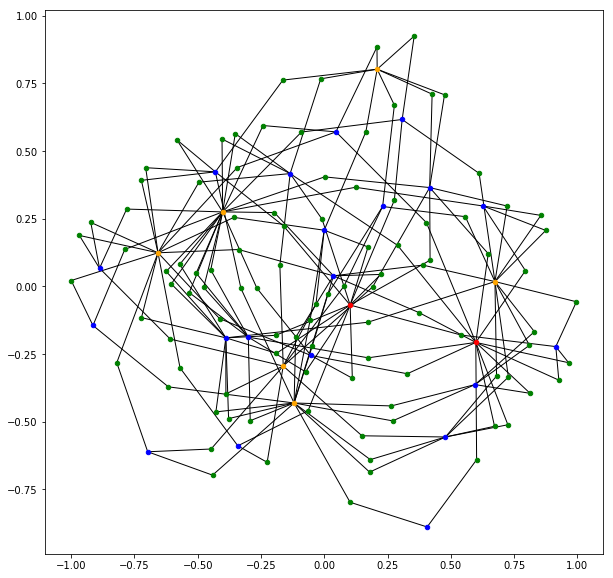

In [9]:
G = nx.Graph()
for k,v in people_dict.items():
    for k2,v2 in v.items():
        if k2 != 'Retail' and k2 != 'Age':
            if v2 > 0:
                G.add_edge(k,v2)

plt.figure(figsize=(10,10))
pos=nx.spring_layout(G)

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(people_dict.keys()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(home_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(school_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_nodes(G,pos,
                      nodelist=list(work_dict.keys()),
                      node_size = 20,
                      node_color='orange')

print("Individuals are Green Nodes")
print("Schools are Red Nodes")
print("Businesses are Yellow Nodes")

nx.draw_networkx_edges(G,pos)
plt.show()

### Visualize as Bipartite Graph

In [10]:
B = nx.Graph()
B.add_nodes_from(list(people_dict.keys()),bipartite=0)
B.add_nodes_from(list(home_dict.keys()),bipartite=1)
B.add_nodes_from(list(school_dict.keys()),bipartite=1)
B.add_nodes_from(list(work_dict.keys()),bipartite=1)

for k,v in people_dict.items():
    for k2,v2 in v.items():
        if k2 != 'Age' and k2 != 'Retail':
            if v2 > 0:
                B.add_edge(k,v2)

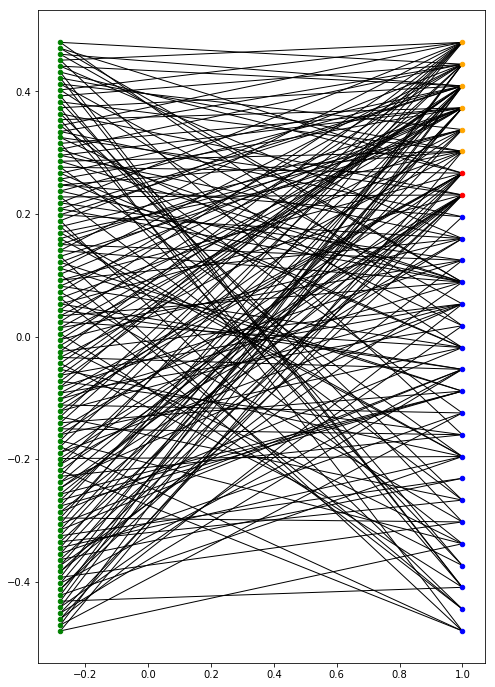

In [11]:
plt.figure(figsize=(8,12))

top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B,top)

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(people_dict.keys()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(home_dict.keys()),
                      node_size = 20,
                      node_color='b')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(school_dict.keys()),
                      node_size = 20,
                      node_color='r')

nx.draw_networkx_nodes(B,pos,
                      nodelist=list(work_dict.keys()),
                      node_size = 20,
                      node_color='orange')

nx.draw_networkx_edges(B,pos)
plt.show()

In [12]:
school_pop = {k: [] for k in list(school_dict.keys())}
work_pop = {k: [] for k in list(work_dict.keys())}
home_pop = {k: [] for k in list(home_dict.keys())}

for k,v in people_dict.items():
    if v['School'] >0:
        school_pop[v['School']].append(k)

for k,v in people_dict.items():
    if v['Work'] >0:
        work_pop[v['Work']].append(k)

for k,v in people_dict.items():
    if v['Home'] >0:
        home_pop[v['Home']].append(k)

In [13]:
G2 = nx.Graph()

school_edges = []
work_edges   = []

for k,v in home_pop.items():
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            G2.add_edge(v[i],v[j])

for k,v in school_pop.items():
    if len(v) > 15:
        r = (math.log(len(v),1.2)//1)/len(v)
    else:
        r = 1
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            if random.random() < r:
                G2.add_edge(v[i],v[j])
                school_edges.append([v[i],v[j]])

for k,v in work_pop.items():
    if len(v) > 15:
        r = (math.log(len(v),1.2)//1)/len(v)
    else:
        r = 1
    for i in range(len(v)-1):
        for j in range(len(v[i+1:])):
            if random.random() < r:
                G2.add_edge(v[i],v[j])
                work_edges.append([v[i],v[j]])



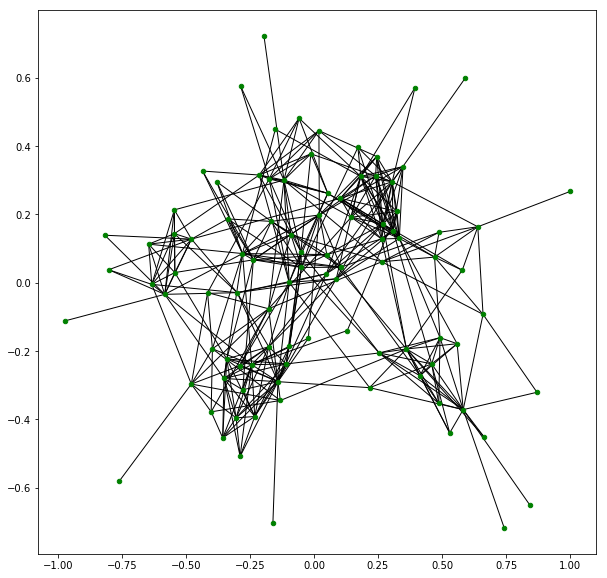

In [14]:
plt.figure(figsize=(10,10))
pos=nx.spring_layout(G2)

nx.draw_networkx_nodes(G2,pos,
                      nodelist=list(G2.nodes()),
                      node_size = 20,
                      node_color='g')

nx.draw_networkx_edges(G2,pos)
plt.show()